In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
from datetime import datetime

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [4]:
#tf.keras.backend.set_floatx('float64')

In [5]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [6]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_809_0515'
train_start = '2000-01-31'
train_end = '2017-01-02'
test_start = '2017-01-02'
test_end = '2020-05-15'

remove_columns = ['date', '종가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'bestpick'
channel = False

trans_day = 1

target_alpha = 100
future_day = 2
train_end_back = -1
n_timestep = 30
time_interval = 2
input_size = 809
n_unit = 1024
batch_size = 10
learning_rate = 0.0005
epochs = 2000

alpha = 0.5
beta = 0.1

comment = "2일 에측을 위해 1일 예측 학습, trainset을 2개로 shuffle로 분리, 그 중 하나만 예측 모델로 학습, 50번 반목하여 best pick, time_interval = 1, 2, 3 병합, loss=model1_1"
best_pick_iter = 50

from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
checkpoint_path = model_name + "/pred"+str(future_day)+":"+now+".ckpt"

In [7]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
df['close'] = df[target_column] # 종가 column 추가, 지존 종가는 rate으로 변환 예정

#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
a = []
b = []
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha 
    df.loc[i, '시가'] = df.loc[i + future_day + train_end_back + 1, '시가']
    a.append(max(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '고가']))
    b.append(min(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '저가']))
for i in range(len(df['종가']) - future_day):
    df.loc[i, '고가'] = a[i]
    df.loc[i, '저가'] = b[i]

In [8]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가,close
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,-0.853010,0.974513,0.827681,0.373581,0.614542,-0.961538,116.55,120.25,115.95,119.60
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,-0.039689,0.193571,1.002058,0.594935,0.706918,3.381014,119.35,123.45,116.80,115.35
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,0.800355,0.031266,0.069626,0.430159,0.725768,3.292528,120.40,123.60,119.75,118.45
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.515992,0.623370,0.378121,0.084769,0.352875,1.677149,122.90,124.10,120.95,119.25
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,3.856851,0.568635,-0.322023,0.518339,0.702038,0.653862,122.40,125.05,120.40,122.35
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,2.657684,1.222974,-0.720402,0.474125,0.440887,1.319588,120.85,125.05,119.85,121.25
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,3.026664,2.114708,-0.407511,0.622228,0.721716,-1.867641,123.60,124.75,115.25,123.15
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,3.316674,1.871659,-0.157431,0.985272,1.379493,-5.575906,118.85,119.00,110.45,122.85
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,2.384344,0.988933,-0.154629,0.473525,0.907189,-8.274721,116.45,116.80,105.25,120.85
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,1.935983,0.085505,-0.246361,0.529501,0.923675,-1.422414,112.05,114.35,105.25,116.00


In [9]:
column_list = df.columns
column_list

Index(['date', '시가지수(포인트)', '고가지수(포인트)', '저가지수(포인트)', '종가지수(포인트)', '수익률(%)',
       '수익률 (1주)(%)', '수익률 (1개월)(%)', '수익률 (3개월)(%)', '수익률 (6개월)(%)',
       ...
       '주요상품선물_금(선물)($/ounce)', '주요상품선물_은(선물)($/ounce)',
       '주요상품선물_알루미늄(선물)($/ton)', '주요상품선물_옥수수(최근월물)(￠/bu)', '대두박(￠/bu)', '종가',
       '시가', '고가', '저가', 'close'],
      dtype='object', length=815)

In [10]:
#import pandas_profiling
#data = df.loc[:, ['미국 SP 500 Index(종가)(Pt)', '거래량(주)', '외국인보유비중(%)', '종가']]
#data = data[:-future_day]
#pr = data.profile_report()
#pr

In [11]:
train_start_index = max(df.loc[df['date']<=train_start].index) + time_interval*(n_timestep-1) - 1
train_end_index = max(df.loc[df['date']<=train_end].index)
base_prices = tf.reduce_mean(df.loc[train_start_index:train_end_index+1, '시가'])  

@tf.function
def loss_fn_model1_1(targets, preds):
 
    loss0 = tf.keras.losses.MSE(targets, preds)
    
    preds = tf.reshape(preds[:, n_timestep-1, :], [-1])
    targets = tf.reshape(targets[:, n_timestep-1, :], [-1])
    
   
    if alpha != 0:
        # add RRL cost - maximize downside sharp ratio

        # 1 if (pred - base) * (target - base) > 0, -1 otherwise
        F = tf.math.sign(targets*preds)
        F = tf.reshape(F, [-1])

        # calc returns from each step in batches
        R = tf.math.divide(tf.math.multiply(tf.math.abs(targets), (F - 0.00003)), base_prices)
        R = tf.reshape(R, [-1])

        # calc downside sharp ratio

        # downside returns
        DR = tf.minimum(0.0, R)
        DR = tf.reshape(DR, [-1])

        # calc. downside sharp ratio
        #s = []
        #for i in range(batch_size):
        #   std =  tf.keras.backend.std(DR[i, :, 0])
        #   s.append(tf.reduce_mean(R[i, :, 0])/tf.maximum(0.01, std))

        # calc. downside sharp ratio
        loss1 = tf.reduce_mean(R) / (tf.keras.backend.std(DR) + 0.001)
    else:
        loss1 = 0

    """
    # average profits, loss
    avg_plusR = [0.0]
    avg_minusR = [0.0]

    global num_of_profits
    global num_of_losses

    num_of_profits = 0
    num_of_losses = 0

    for i in range(batch_size):
        res = tf.cond(R[i, num_steps - 1, 0] > 0, lambda: return_one(), lambda: return_zero())
        if res == 1:
            avg_plusR.append(R[i, num_steps - 1, 0])
        else:
            avg_minusR.append(R[i, num_steps - 1, 0])
    avg_profit = tf.reduce_mean(avg_plusR) 
    avg_loss = tf.reduce_mean(avg_minusR) 
    """

    if beta != 0:
        #compute maximum drawdown

        #accm_profit = [0.0]
        #for i in range(batch_size):
        #    for j in range(num_steps):
        #        r = tf.cond((predict_prices[i, num_steps-1, 0] - base_prices[i, num_steps-1, 0]) *
        #                   (target_prices[i, num_steps-1, 0] - base_prices[i, num_steps-1, 0]) > 0,
        #                   lambda: return_one(),
        #                   lambda: return_zero())
        #        if r == 1: accm_profit.append(accm_profit[i*num_steps + j] + tf.abs(target_prices[i, j, 0] - base_prices[i, j, 0]))
        #        else:      accm_profit.append(accm_profit[i*num_steps + j] - tf.abs(target_prices[i, j, 0] - base_prices[i, j, 0]))

        accm_profit = [0.0 for i in range(batch_size)]
        for i in range(batch_size):
            if i == 0:
                accm_profit[0] = tf.sign(preds * targets) * tf.math.abs(targets)
            else:
                accm_profit[i] = accm_profit[i-1] + tf.sign(preds * targets) * tf.math.abs(targets)
        loss2 = (tf.reduce_max(accm_profit) - tf.reduce_min(accm_profit))/batch_size
    else:
        loss2 = 0

    return loss0 + beta*loss2 - alpha*loss1

In [12]:
#@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    train_y_target = np.expand_dims(train_y[:, :, 4], axis=2)
    
    rates = train_y_target / 100
    updown = tf.math.sign(train_y_target)
    preds = tf.cast(tf.math.sign(m1(train_x)), dtype=tf.float64)
    profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds, dtype=tf.float64)
    
    batches = tf.cast(train_y.shape[0], dtype=tf.int32)
    steps = train_y.shape[1]     
    
    # 시가, 고가, 저가
    train_open = np.expand_dims(train_y[:, :, 0], axis=2)   
    train_high = np.expand_dims(train_y[:, :, 1], axis=2)
    train_low = np.expand_dims(train_y[:, :, 2], axis=2)
    train_base = np.expand_dims(train_y[:, :, 3], axis=2)
    train_real = train_base * (rates + 1)
    
    targets = train_y_target.copy()
    targets[:, -max(1, int(future_day/time_interval)):, :] = 0
    train_x_m2 = tf.concat([preds, targets, train_open, train_high, train_low], 2)
    loss_cuts = tf.cast(tf.reshape(m2(train_x_m2)[:, -1, 0], [-1]), dtype=tf.float64)
    
    # 손절 손익 계산
    loss_cut_targets = []
    for i in range(batches):

        if preds[i, -1, 0] > 0:
            if rates[i, -1, 0] > 0: 
                loss_cut_targets.append(train_open[i, -1, 0] - train_low[i, -1, 0])
            else:
                loss_cut_targets.append((train_base[i, -1, 0] - train_real[i, -1, 0])*0.5)
        else:
            if rates[i, -1, 0] > 0: 
                loss_cut_targets.append((train_real[i, -1, 0] - train_base[i, -1, 0])*0.5)
            else:
                loss_cut_targets.append(train_high[i, -1, 0] - train_open[i, -1, 0])
                    
    return tf.keras.losses.MSE(loss_cuts, loss_cut_targets)


In [13]:
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [14]:
#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
"""
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_timestep, input_size)),
    tf.keras.layers.LSTM(n_unit, return_sequences=True),
    tf.keras.layers.LSTM(n_unit, return_sequences=True),    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model1.summary()
"""

"\nmodel1 = tf.keras.Sequential([\n    tf.keras.Input(shape=(n_timestep, input_size)),\n    tf.keras.layers.LSTM(n_unit, return_sequences=True),\n    tf.keras.layers.LSTM(n_unit, return_sequences=True),    \n    tf.keras.layers.Dense(64, activation='relu'),\n    tf.keras.layers.Dense(1)\n])\nmodel1.summary()\n"

In [15]:
print("학습 시작")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))

best_prediction = []
best_accu = 0
for n in range(best_pick_iter):
    
    gc.collect()

    model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)

    model1.compile(optimizer='adam',
                  loss=loss_fn_model1_1)
                      #callbacks=[cp-callback]
                  #metrics=['accuracy'])
    model1.save_weights(checkpoint_path) 
    
    current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
    current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
    current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
    current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']

    #  각 transfer 구간의 예측값들을 합치기 위하여
    test_prediction = []
    cnt = 0
    while True:
        cnt += 1
        gc.collect()

        time_interval = np.random.randint(1, 4)
        
        train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                               current_train_start, current_train_end,
                                                               current_test_start, current_test_end,
                                                               future_day, n_timestep, time_interval)

        # 전체 train, test dataset 생성
        train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
        train_x = train_x[:train_end_back]
        train_y = train_y[:train_end_back]

        test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)
        test_y_target = np.expand_dims(test_y[:, :, 4], axis=2)    

        # train, validation set 분리하여 train1은 예측모델로 train2는 손절값 학습 모델로 사용
        train1_x, train2_x, train1_y, train2_y = train_test_split(train_x, train_y, test_size=0.65)


        # the model1 training
        train1_y_target = np.expand_dims(train1_y[:, :, 4], axis=2)
        early_stopping1 = tf.keras.callbacks.EarlyStopping(patience=2, verbose=0)
        model1.load_weights(checkpoint_path)
        model1.fit(train1_x, train1_y_target, batch_size=batch_size, verbose=0, epochs=3, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
        model1.save_weights(checkpoint_path)

        if cnt % 100 == 0:
            print('test dates ' + current_test_start + "~" + current_test_end)

        # prediction1 accuracy
        updown = np.sign(test_y[:, -1, 4]).reshape((-1))
        prediction = model1.predict(test_x)[:, -1, 0].reshape(-1)
        #temp = tf.math.multiply(updown, prediction1)
        #accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
        #print('prediction1 accuracy = ', accu)

        test_prediction.append(prediction)
        #test_prediction2.append(prediction2)

        # escape from while
        if current_test_end == test_end:
         break

        #train, start dates shift
        current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
        current_train_start = df.loc[prepro.date_to_index(df, current_train_end) - 1000, 'date']
        current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
        if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
            current_test_end = test_end
        else:
            current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']
    
    t = np.concatenate(test_prediction)    
    
    print("구간 " + str(n) + " 학습 종료.......")
    print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))
    
    # 구간 n에 대한 accuracy 계산을 위한 data
    test_start_index = prepro.date_to_index(df, test_start)
    test_end_index = prepro.date_to_index(df, test_end)
    test_open_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '시가']))
    test_base_prices = np.array(list(map(float, dataframe.loc[test_start_index - future_day: test_end_index - future_day, '종가']))) 
    test_output_prices = np.array(list(map(float, dataframe.loc[test_start_index: test_end_index, '종가'])))   
    test_predict_prices = test_base_prices * (np.array(t)/100 + 1)

    # 전체 test_oouput 생성
    _, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                       train_start, train_end,
                                                       test_start, test_end,
                                                       future_day, n_timestep, time_interval)
    _, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)    
    
    # 예측확률 계산 -종가 대비
    updown = np.sign(test_y[:, -1, 4]).reshape((-1))
    temp = tf.math.multiply(updown, t.reshape((-1)))
    close_accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('종가대비 예측확률 = ', close_accu) 
    
    # 예측확률 계산 -시가 대비
    cnt = 0
    for i in range(len(test_predict_prices)):
        if (test_predict_prices[i]-test_open_prices[i])*(test_output_prices[i]-test_open_prices[i]) > 0:
            cnt += 1
    accu = cnt/len(test_predict_prices)
    print('시가대비 예측확률 = ', accu)    
    
    # best 에측 확률 저장
    if accu > best_accu: 
        best_accu = accu
        best_prediction = t

    print('시가대비 best accuracy = ', best_accu)

학습 시작
2020-06-26:00:44:27
test dates 2017-05-30~2017-05-30
test dates 2017-10-27~2017-10-27
test dates 2018-03-26~2018-03-26
test dates 2018-08-21~2018-08-21
test dates 2019-01-18~2019-01-18
test dates 2019-06-18~2019-06-18
test dates 2019-11-12~2019-11-12
test dates 2020-04-07~2020-04-07
구간 0 학습 종료.......
2020-06-26:01:24:27
종가대비 예측확률 =  tf.Tensor(0.5327669902912622, shape=(), dtype=float64)
시가대비 예측확률 =  0.5097087378640777
시가대비 best accuracy =  0.5097087378640777
test dates 2017-05-30~2017-05-30
test dates 2017-10-27~2017-10-27
test dates 2018-03-26~2018-03-26
test dates 2018-08-21~2018-08-21
test dates 2019-01-18~2019-01-18
test dates 2019-06-18~2019-06-18
test dates 2019-11-12~2019-11-12
test dates 2020-04-07~2020-04-07
구간 1 학습 종료.......
2020-06-26:02:00:48
종가대비 예측확률 =  tf.Tensor(0.5097087378640777, shape=(), dtype=float64)
시가대비 예측확률 =  0.5
시가대비 best accuracy =  0.5097087378640777
test dates 2017-05-30~2017-05-30
test dates 2017-10-27~2017-10-27
test dates 2018-03-26~2018-03-26
test

test dates 2020-04-07~2020-04-07
구간 18 학습 종료.......
2020-06-26:12:44:20
종가대비 예측확률 =  tf.Tensor(0.5012135922330098, shape=(), dtype=float64)
시가대비 예측확률 =  0.5145631067961165
시가대비 best accuracy =  0.5315533980582524
test dates 2017-05-30~2017-05-30
test dates 2017-10-27~2017-10-27
test dates 2018-03-26~2018-03-26
test dates 2018-08-21~2018-08-21
test dates 2019-01-18~2019-01-18
test dates 2019-06-18~2019-06-18
test dates 2019-11-12~2019-11-12
test dates 2020-04-07~2020-04-07
구간 19 학습 종료.......
2020-06-26:13:25:22
종가대비 예측확률 =  tf.Tensor(0.5351941747572816, shape=(), dtype=float64)
시가대비 예측확률 =  0.5230582524271845
시가대비 best accuracy =  0.5315533980582524
test dates 2017-05-30~2017-05-30
test dates 2017-10-27~2017-10-27
test dates 2018-03-26~2018-03-26
test dates 2018-08-21~2018-08-21
test dates 2019-01-18~2019-01-18
test dates 2019-06-18~2019-06-18
test dates 2019-11-12~2019-11-12
test dates 2020-04-07~2020-04-07
구간 20 학습 종료.......
2020-06-26:14:06:54
종가대비 예측확률 =  tf.Tensor(0.520631067961165

test dates 2017-10-27~2017-10-27
test dates 2018-03-26~2018-03-26
test dates 2018-08-21~2018-08-21
test dates 2019-01-18~2019-01-18
test dates 2019-06-18~2019-06-18
test dates 2019-11-12~2019-11-12
test dates 2020-04-07~2020-04-07
구간 37 학습 종료.......
2020-06-27:01:59:54
종가대비 예측확률 =  tf.Tensor(0.5097087378640777, shape=(), dtype=float64)
시가대비 예측확률 =  0.49393203883495146
시가대비 best accuracy =  0.5315533980582524
test dates 2017-05-30~2017-05-30
test dates 2017-10-27~2017-10-27
test dates 2018-03-26~2018-03-26
test dates 2018-08-21~2018-08-21
test dates 2019-01-18~2019-01-18
test dates 2019-06-18~2019-06-18
test dates 2019-11-12~2019-11-12
test dates 2020-04-07~2020-04-07
구간 38 학습 종료.......
2020-06-27:02:43:06
종가대비 예측확률 =  tf.Tensor(0.5072815533980582, shape=(), dtype=float64)
시가대비 예측확률 =  0.5121359223300971
시가대비 best accuracy =  0.5315533980582524
test dates 2017-05-30~2017-05-30
test dates 2017-10-27~2017-10-27
test dates 2018-03-26~2018-03-26
test dates 2018-08-21~2018-08-21
test dates 2

In [16]:
updown = np.sign(test_y[:, -1, 4]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, best_prediction.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('종가대비 best 예측확률 = ', accu)

종가대비 best 예측확률 =  tf.Tensor(0.4878640776699029, shape=(), dtype=float64)


In [17]:
# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴 - 종가를 test base price로 하는 경우
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)
result = GenerateResult(best_prediction, best_prediction, test_y[:, -1, 4].reshape(-1), test_dates, n_timestep, future_day, train_end_back, trans_day)

#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

# 손익 계산
test_start_index = prepro.date_to_index(df, test_start)
test_end_index = prepro.date_to_index(df, test_end)
test_open_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '시가']))
test_high_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '고가']))
test_low_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '저가']))
profits = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if result.test_predict_price[i]-test_open_prices[i] > 0:
        profits[i] = result.test_output_price[i] - test_open_prices[i]
    else:
        profits[i] = test_open_prices[i] - result.test_output_price[i]
"""
# 손절 손익 계산
profits2 = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if t2[i] <= 0: profits2[i] = profits[i]
    else:
        if result.test_predict_price[i] - test_open_prices[i] > 0:
            if test_open_prices[i] - test_low_prices[i] > t2[i]:
                profits2[i] = -t2[i]
            else:
                profits2[i] = profits[i]
        else:
            if test_high_prices[i] - test_open_prices[i] > t2[i]:
                profits2[i] = -t2[i]
            else:
                profits2[i] = profits[i]
"""

'\n# 손절 손익 계산\nprofits2 = np.zeros(len(test_dates))\nfor i in range(len(test_dates)):\n    if t2[i] <= 0: profits2[i] = profits[i]\n    else:\n        if result.test_predict_price[i] - test_open_prices[i] > 0:\n            if test_open_prices[i] - test_low_prices[i] > t2[i]:\n                profits2[i] = -t2[i]\n            else:\n                profits2[i] = profits[i]\n        else:\n            if test_high_prices[i] - test_open_prices[i] > t2[i]:\n                profits2[i] = -t2[i]\n            else:\n                profits2[i] = profits[i]\n'

info : bestpick_kospi200f_809_0515_06-27:10:12_2_0.538
MSE : 26.1444 , Accuracy : 0.538


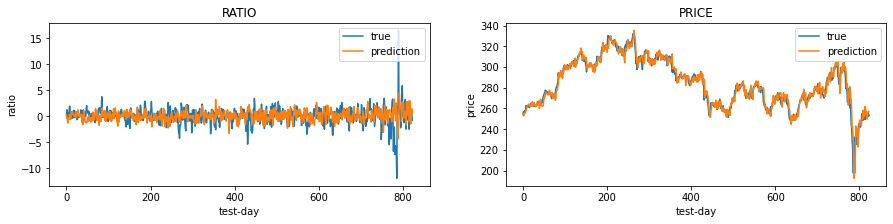

In [18]:
preds = np.array(result.test_predict_price) - np.array(test_open_prices)
trues = np.array(result.test_output_price) - np.array(test_open_prices)
result.evaluation(preds, trues)
result.table(test_open_prices, test_high_prices, test_low_prices, profits, profits)
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
#result.save_model(model2)

In [19]:
"""
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
"""

'\ncurrent_train_start = df.loc[prepro.date_to_index(df, train_start), \'date\']\ncurrent_train_end = df.loc[prepro.date_to_index(df, train_end), \'date\']\ncurrent_test_start = df.loc[prepro.date_to_index(df, test_start), \'date\']\ncurrent_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, \'date\']\n\n\n#  각 transfer 구간의 예측값들을 합치기 위하여\ntest_prediction1 = []\ntest_prediction2 = []\ntest_target = []\n\n# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)\nearly_stopping = learn.EarlyStopping(patience=2, verbose=1)\n\n\ngc.collect()\n\ntrain_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, \n                                                       current_train_start, current_train_end,\n                                                       current_test_start, current_test_end,\n                                                       future_day, n_timestep, time_interval)\n\n# input_size, columns reset\ninput_size 